In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import astropy.constants as const
au = const.au.cgs.value
Msun = const.M_sun.cgs.value
yr = 365*24*3600

# 1. Compute and save opacity table

In [2]:
from disk_model import generate_opacity_table

load_opacity = True

if not load_opacity:
    opacity_table = generate_opacity_table(
        a_min=0, a_max=0.1, # min/max grain size
        q=-3.5, # slope for dust size distribution, dn/da ~ a^q
        dust_to_gas=0.01, # dust-to-gas ratio before sublimation
    )
    opacity_table_fname = './data/opacity_tables/kappa_1mm.pkl'
    with open(opacity_table_fname,"wb") as f:
        pickle.dump(opacity_table, f)
else:
    opacity_table_fname = './data/opacity_tables/kappa_1mm.pkl'
    with open(opacity_table_fname,"rb") as f:
        opacity_table = pickle.load(f)

In [3]:
T = opacity_table['T']
lam = opacity_table['lam']
kappa = opacity_table['kappa']
kappa_p = opacity_table['kappa_p']
kappa_r = opacity_table['kappa_r']

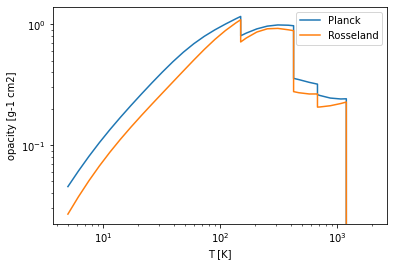

In [4]:
plt.plot(T, kappa_p)
plt.plot(T, kappa_r)
plt.xscale('log'); plt.xlabel('T [K]')
plt.yscale('log'); plt.ylabel('opacity [g-1 cm2]')
plt.legend(['Planck','Rosseland','0.87 mm','9 mm'])
plt.show()

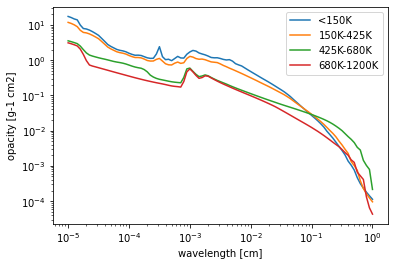

In [5]:
plt.plot(lam, kappa[0])
plt.plot(lam, kappa[1])
plt.plot(lam, kappa[2])
plt.plot(lam, kappa[3])
plt.xscale('log'); plt.xlabel('wavelength [cm]')
plt.yscale('log'); plt.ylabel('opacity [g-1 cm2]')
# 150, 425, 680, 1200
plt.legend(['<150K', '150K-425K', '425K-680K', '680K-1200K'])
plt.show()

# 2.  Compute and save a mapping from ($T_{eff}$, $\Sigma/\bar{c_s}$) to other local disk properties

In [6]:
from disk_model import generate_disk_property_table

load_disk_property = True

if not load_disk_property:
    disk_property_table = generate_disk_property_table(
        opacity_table = opacity_table,
    )
    disk_property_table_fname = './data/disk_property_tables/disk_property_1mm.pkl'
    with open(disk_property_table_fname,"wb") as f:
        pickle.dump(disk_property_table, f)
else:
    disk_property_table_fname = './data/disk_property_tables/disk_property_1mm.pkl'
    with open(disk_property_table_fname,"rb") as f:
        disk_property_table = pickle.load(f)

# 3. DiskModel class: parametrized disk model

In [8]:
from disk_model import DiskModel

DM = DiskModel(
    opacity_table=opacity_table,
    disk_property_table=disk_property_table,
)

In [9]:
DM.generate_disk_profile(Mstar=0.5*Msun, Rd=50*au, Mdot=1e-5*Msun/yr, Q=1.5)

In [10]:
DM.set_lam_obs_list([0.087, 0.9])
DM.generate_observed_flux(cosI=0.5)

3.7013209282935117e-13


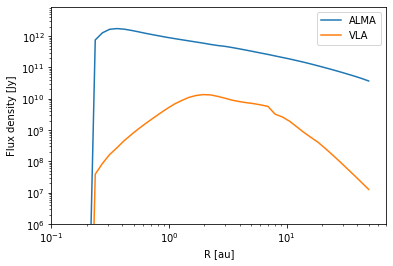

In [11]:
R_au = DM.R[1:]/au
plt.plot(R_au, DM.F_obs[0]*1e23)
plt.plot(R_au, DM.F_obs[1]*1e23)
plt.xscale('log'); plt.xlabel('R [au]')
plt.yscale('log'); plt.ylabel('Flux density [Jy]')
plt.legend(['ALMA','VLA'])
plt.xlim(1e-1,None)
plt.ylim(1e6,None)
plt.show()

# 4. DiskImage class

In [2]:
import astropy.table
data = astropy.table.Table.read("./data/VANDAM_T20_properties.txt", format="ascii")
data.add_index('Source') # add index by source
i = data.loc_indices['HOPS-409']

In [3]:
from disk_model import DiskImage

# download image files
from stats_and_visualizations.download_vandam_image import download_image
download_image('HOPS-409', obs='both', folder='./data/observation', verbose=True)

# initialize DiskImage objects
DI_alma = DiskImage(
    fname = './data/observation/HOPS-409_cont_robust0.5.pbcor.fits',
    ra_deg = data[i]['A_RA_deg'],
    dec_deg = data[i]['A_DEC_deg'],
    distance_pc = data[i]['DistanceA'],
    rms_Jy = data[i]['A_RMS']*1e-3, # convert to Jy/beam
    disk_pa = data[i]['A_dPA'],
    img_size_au = max(400, 2*data[i]['RdiskA']),
)

DI_vla = DiskImage(
    fname = './data/observation/HOPS-409.A.Ka.cont.0.5.robust.image.pbcor.fits',
    ra_deg = data[i]['V_RA_deg'],
    dec_deg = data[i]['V_DEC_deg'],
    distance_pc = data[i]['DistanceA'],
    rms_Jy = data[i]['V_RMS']*1e-6, # convert to Jy/beam
    disk_pa = data[i]['A_dPA'], # use the ALMA estimate for disk orientation
    img_size_au = max(400, 2*data[i]['RdiskA']),
)

file name: HOPS-409_cont_robust0.5.pbcor.fits
file already exists, skipping download
file name: HOPS-409.A.Ka.cont.0.5.robust.image.pbcor.fits
file already exists, skipping download


# 5. DiskFitting class: fit model to multi-wavelength observation
### The .pkl files in ./data/fitted/systems contain lists of fitted DiskFitting objcts.

In [14]:
from disk_model import DiskFitting

D = DiskFitting('HOPS-409' ,opacity_table, disk_property_table)

cosI = data[i]['A_dBmin']/data[i]['A_dBmaj']
D.set_cosI(cosI)

D.add_observation(DI_alma, 0.087)
D.add_observation(DI_vla, 0.9)

In [15]:
D.fit() # see documentation of this function for fitting options (e.g. set Q and relation between Mdot and Mstar)

### automate the process above

In [21]:
from disk_model import fit_vandam_image

D = fit_vandam_image('HOPS-409')

Finished HOPS-409, took 15.696605920791626 sec.


### obtaining disk properties (see more examples in ./stats_and_visualizations)

In [ ]:
print('M_star [M_sun] =',D.disk_model.Mstar/Msun)
print('M_disk [M_sun] =',(D.disk_model.M-D.disk_model.Mstar)/Msun)
print('R_disk [au] =',D.disk_model.Rd/au)